#by Bekhzodbek Mukhammadaliev


###Task: Stock Market Prediction using Numerical and Textual Analysis

Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

Stock to analyse and predict - INFY (Infosys Limited)

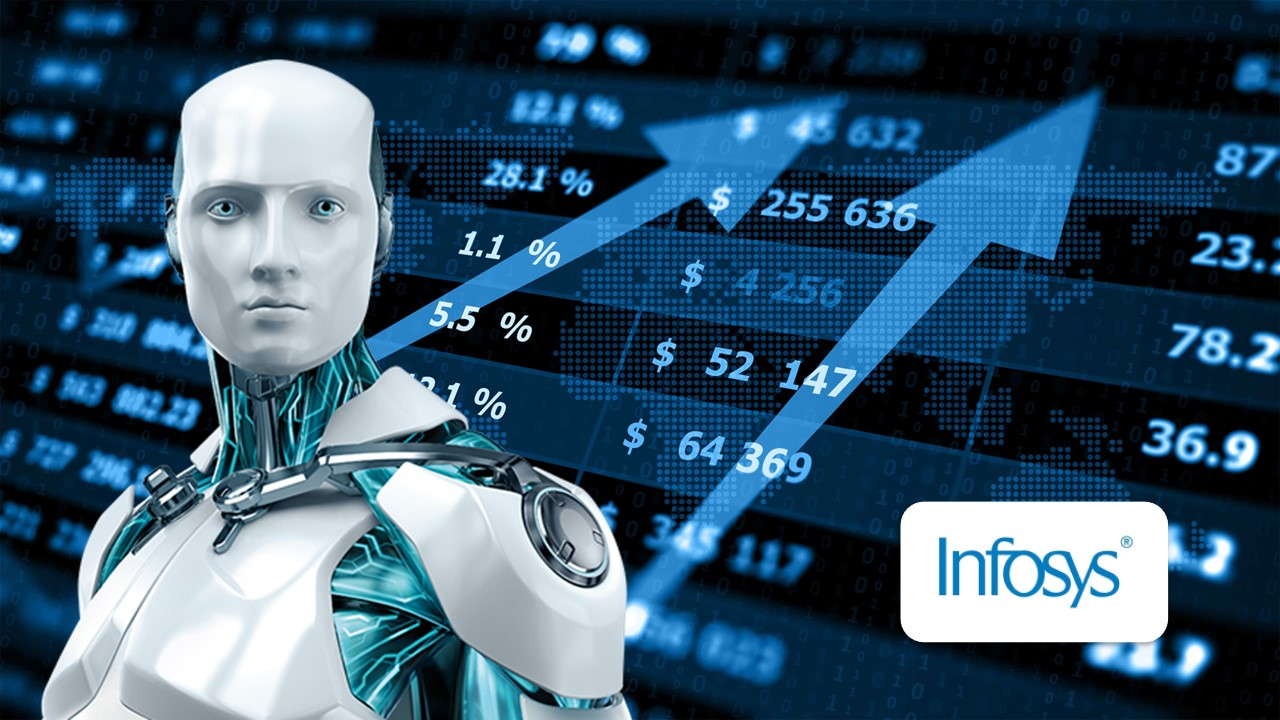

In [25]:
import pandas as pd
import numpy as np
import yfinance as yf

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the stock symbol and date range
stock_symbol = "INFY"
start_date = "2003-05-18"
end_date = "2023-05-18"

# Download historical stock prices
stock_prices = yf.download(stock_symbol, start=start_date, end=end_date)

prices = pd.DataFrame(stock_prices).reset_index()

prices

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-05-19,1.306250,1.309375,1.257813,1.285938,0.878894,10038400
1,2003-05-20,1.301563,1.335938,1.285938,1.314063,0.898117,5180800
2,2003-05-21,1.312500,1.312500,1.289688,1.296875,0.886369,1209600
3,2003-05-22,1.281250,1.306250,1.274688,1.289063,0.881030,3238400
4,2003-05-23,1.281563,1.281563,1.256250,1.268125,0.866720,7497600
...,...,...,...,...,...,...,...
5030,2023-05-11,15.200000,15.200000,15.010000,15.030000,15.030000,15960000
5031,2023-05-12,15.000000,15.110000,14.980000,15.080000,15.080000,10854500
5032,2023-05-15,15.130000,15.380000,15.080000,15.340000,15.340000,8921200
5033,2023-05-16,15.250000,15.280000,15.100000,15.110000,15.110000,13214600


In [3]:
news = pd.read_csv("/content/india-news-headlines.csv", names=['Date', 'Category', 'News'])
news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [4]:
news.drop('Category', axis = 1, inplace=True)
news.drop(0, inplace=True)

In [5]:
#Converting date objects into datatime data types
news["Date"] = pd.to_datetime(news["Date"],format='%Y%m%d')
news.head()

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic


In [6]:
# Group the headlines for each day
news['News'] = news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
news = news.drop_duplicates() 
news.reset_index(inplace=True,drop=True)

In [7]:
#removing unwanted characters from the News
news.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
news["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

###Numerical Analysis

Perform exploratory data analysis (EDA) and extract relevant numerical features.

In [8]:
# Example: Calculating moving averages
prices['MA50'] = prices['Close'].rolling(window=50).mean()
prices['MA200'] = prices['Close'].rolling(window=200).mean()

# Example: Calculate percentage change in closing prices
prices['PriceChange'] = prices['Close'].pct_change()

prices

,Date,Open,High,Low,Close,Adj Close,Volume,MA50,MA200,PriceChange
0,2003-05-19,1.306250,1.309375,1.257813,1.285938,0.878894,10038400,NaN,NaN,NaN
1,2003-05-20,1.301563,1.335938,1.285938,1.314063,0.898117,5180800,NaN,NaN,0.021871
2,2003-05-21,1.312500,1.312500,1.289688,1.296875,0.886369,1209600,NaN,NaN,-0.013080
3,2003-05-22,1.281250,1.306250,1.274688,1.289063,0.881030,3238400,NaN,NaN,-0.006024
4,2003-05-23,1.281563,1.281563,1.256250,1.268125,0.866720,7497600,NaN,NaN,-0.016243
...,...,...,...,...,...,...,...,...,...,...
5030,2023-05-11,15.200000,15.200000,15.010000,15.030000,15.030000,15960000,16.4218,18.10055,-0.017647
5031,2023-05-12,15.000000,15.110000,14.980000,15.080000,15.080000,10854500,16.3616,18.08240,0.003327
5032,2023-05-15,15.130000,15.380000,15.080000,15.340000,15.340000,8921200,16.3048,18.06335,0.017241
5033,2023-05-16,15.250000,15.280000,15.100000,15.110000,15.110000,13214600,16.2418,18.04145,-0.014994


Text(0, 0.5, 'Infosys')

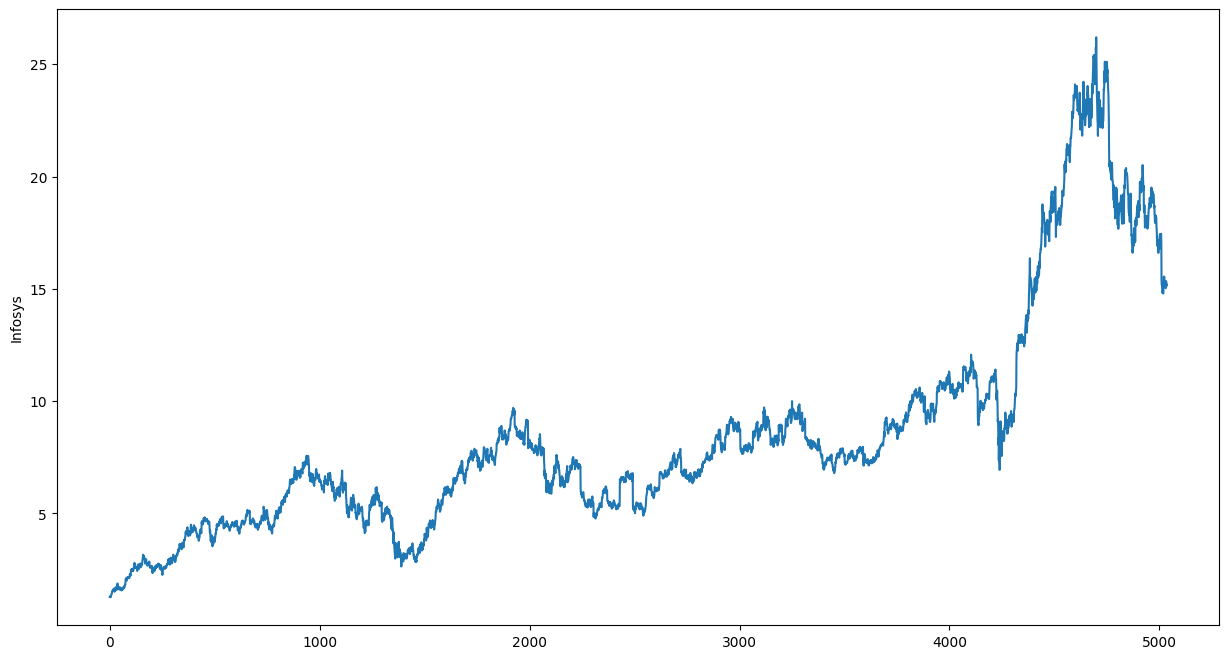

In [9]:
# Figure plot
plt.figure(figsize=(15,8))
prices['Close'].plot()
plt.ylabel('Infosys')

<Axes: >

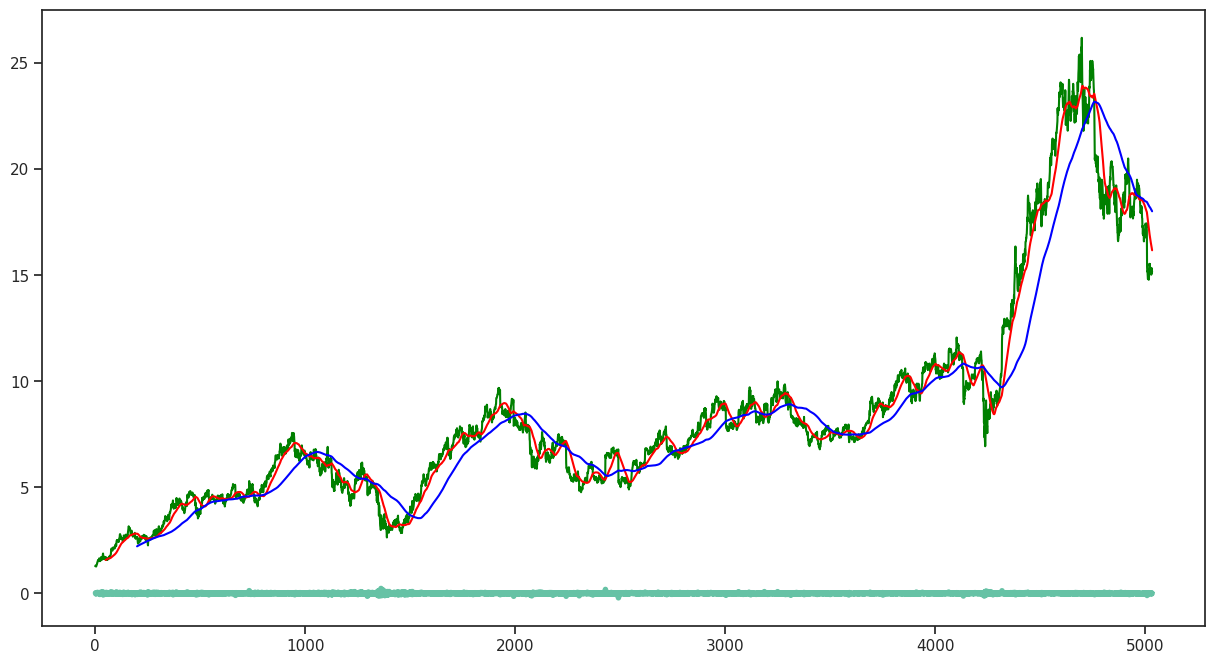

In [65]:
#Ploting Moving Average
plt.figure(figsize=(15,8))
prices['Close'].plot(color ='g', label='Close')
prices['MA50'].plot(color='r', label='MA50')
prices['MA200'].plot(color='b', label='MA200')
prices['PriceChange'].plot(label='PriceChange', linewidth=4)

##Sentimental Analysis

In [11]:
# Download required resources for sentiment analysis
nltk.download('vader_lexicon')

# Perform sentiment analysis
sia = SentimentIntensityAnalyzer()
news['Compound'] = news['News'].apply(lambda x: sia.polarity_scores(x)['compound'])
news['Negative'] = news['News'].apply(lambda x: sia.polarity_scores(x)['neg'])
news['Neutral'] = news['News'].apply(lambda x: sia.polarity_scores(x)['neu'])
news['Positive'] = news['News'].apply(lambda x: sia.polarity_scores(x)['pos'])

news

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Date,News,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,-0.9999,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,-0.9999,0.156,0.769,0.076


###Model Integration

In [35]:
# Merge the numerical and sentiment data
merged_data = prices.merge(news, how='inner', on='Date')

# Select relevant features for the hybrid model
selected_features = ['Compound', 'Negative', 'Neutral', 'Positive', 'Close']

# Create the final dataset for model training
final_data = merged_data[selected_features].dropna()


##EDA Visualization

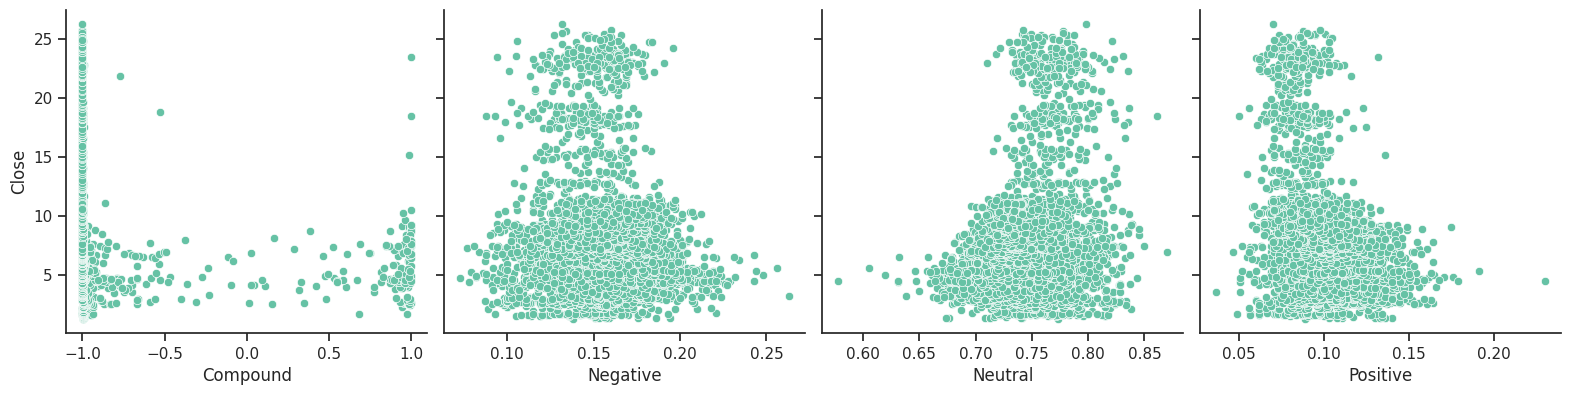

In [37]:
sns.set(style="ticks", palette="Set2")
sns.pairplot(final_data, x_vars=['Compound', 'Negative', 'Neutral', 'Positive'], y_vars='Close', height=4)
plt.show()

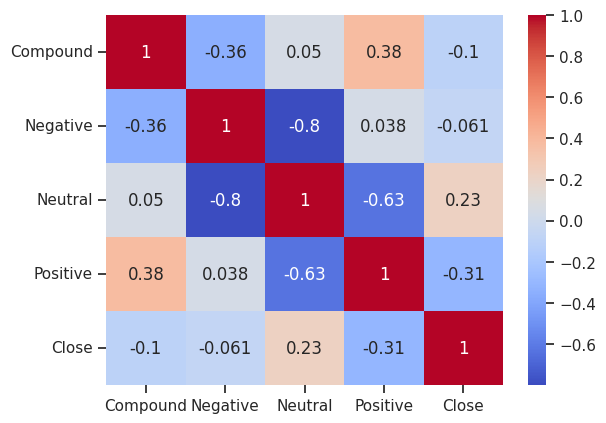

In [38]:
# Bivariate Analysis
corr_matrix = final_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


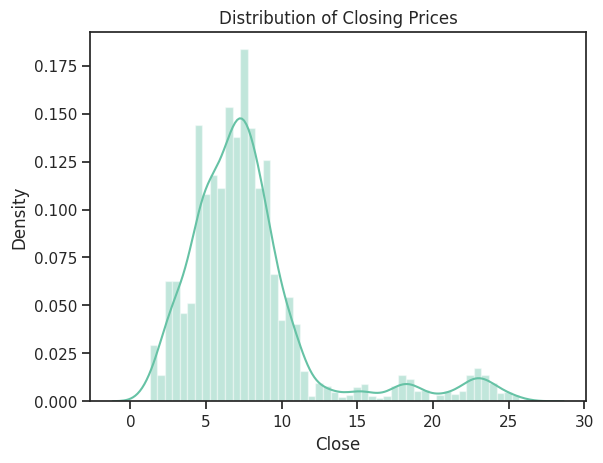

In [39]:
# Univariate Analysis
sns.distplot(final_data['Close'])
plt.title('Distribution of Closing Prices')
plt.show()

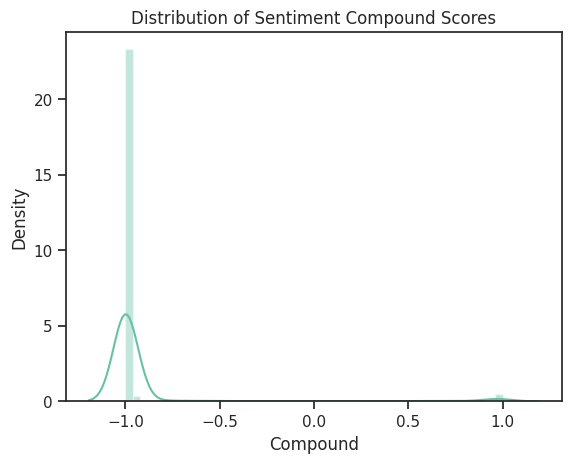

In [40]:
sns.distplot(final_data['Compound'])
plt.title('Distribution of Sentiment Compound Scores')
plt.show()

##Normalize Data

In [41]:
scaler = MinMaxScaler()

scaled = pd.DataFrame(scaler.fit_transform(final_data))
scaled.columns = final_data.columns
scaled.index = final_data.index
scaled.head()

,Compound,Negative,Neutral,Positive,Close
0,0.00030,0.636842,0.335616,0.481865,0.000714
1,0.00155,0.452632,0.445205,0.497409,0.001843
2,0.00040,0.542105,0.462329,0.383420,0.001153
3,0.00035,0.594737,0.328767,0.533679,0.000840
4,0.00095,0.342105,0.667808,0.269430,0.000000


##Train & Test Split

In [42]:
# Split the data into training and testing sets
X = scaled.iloc[:, :-1]
y = scaled.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Model Training and Evaluation

###Linear Regression

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test,y_pred)
mse_lr= mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
r2_lr = round(lr.score(X_train,y_train) * 100,2)

print(f"MAE: {mae_lr}")
print(f"RMSE: {rmse_lr}")
print(f"R-squared: {r2_lr}")

MAE: 0.11662833441495059
RMSE: 0.16799445991925074
R-squared: 10.24


###Ridge Regression

In [52]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mae_rid = mean_absolute_error(y_test,y_pred)
mse_rid = mean_squared_error(y_test, y_pred)
rmse_rid = np.sqrt(mse_rid)
r2_rid = round(ridge.score(X_train,y_train) * 100,2)

print(f"MAE: {mae_rid}")
print(f"RMSE: {rmse_rid}")
print(f"R-squared: {r2_rid}")

MAE: 0.11645806024395608
RMSE: 0.16791834312979845
R-squared: 10.24


###Lasso Regression

In [53]:
# Lasso Regression
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mae_las = mean_absolute_error(y_test,y_pred)
mse_las = mean_squared_error(y_test, y_pred)
rmse_las = np.sqrt(mse_las)
r2_las = round(lasso.score(X_train,y_train) * 100,2)

print(f"MAE: {mae_las}")
print(f"RMSE: {rmse_las}")
print(f"R-squared: {r2_las}")

MAE: 0.1178685825766566
RMSE: 0.17523424938899101
R-squared: 0.0


###Rendom Forest Regressor

In [46]:
# Hyperparameter tuning for RandomForestRegressor
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(rf, rf_params, scoring='neg_mean_squared_error', cv=3, n_iter=10, verbose=0, random_state=42)
rf_random.fit(X_train, y_train)

print("Best parameters for RandomForestRegressor: ", rf_random.best_params_)

Best parameters for RandomForestRegressor:  {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7}


In [54]:
rf = RandomForestRegressor(n_estimators= 400, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test,y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = round(rf.score(X_train,y_train) * 100,2)

print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R-squared: {r2_rf}")

MAE: 0.09887647394909518
RMSE: 0.14918933759116076
R-squared: 86.68


###XGBoost Regressor

In [59]:

# Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

xgb = XGBRegressor(random_state=42)
xgb_random = RandomizedSearchCV(xgb, xgb_params, scoring='neg_mean_squared_error', cv=3, n_iter=10, verbose=0, random_state=42)
xgb_random.fit(X_train, y_train)

print("Best parameters for XGBoost: ", xgb_random.best_params_)


Best parameters for XGBoost:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [56]:
xgb = XGBRegressor(n_estimators=400, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test,y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = round(xgb.score(X_train,y_train) * 100,2)

print(f"MAE: {mae_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R-squared: {r2_xgb}")

MAE: 0.10890159969068736
RMSE: 0.16706660323867634
R-squared: 92.31


##Results

In [57]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rid, mae_las, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_rid, rmse_las, rmse_rf, rmse_xgb],
    'R-squared': [r2_lr, r2_rid, r2_las, r2_rf, r2_xgb]
})

results.sort_values(by='R-squared', ascending=False, inplace=True)
print(results)

               Model       MAE      RMSE  R-squared
4            XGBoost  0.108902  0.167067      92.31
3      Random Forest  0.098876  0.149189      86.68
0  Linear Regression  0.116628  0.167994      10.24
1   Ridge Regression  0.116458  0.167918      10.24
2   Lasso Regression  0.117869  0.175234       0.00
